Total files found: 400

Tumor file sample:
File: UPENN-GBM-00567_11_T1.nii.gz
Volume shape (should be Axial view, e.g., (X, Y, Z)):  (240, 240, 155)

Non-Tumor file sample:
File: IXI063-Guys-0742-T1.nii.gz
Volume shape (should be Axial view, e.g., (X, Y, Z)):  (150, 256, 256)


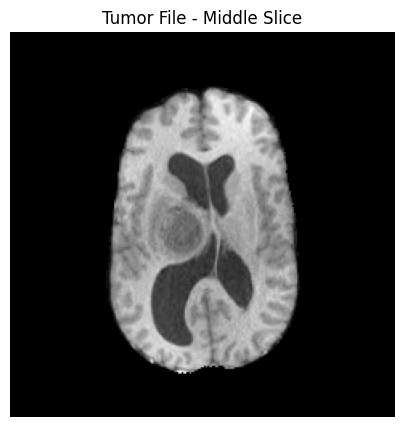

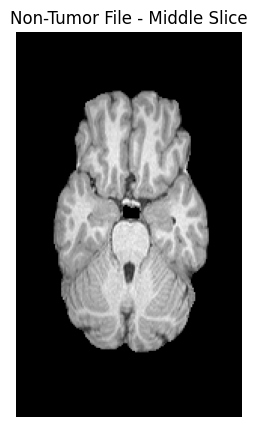

In [ ]:
# Step 1: Import Libraries and Define File-Loading Functions

import os
import nibabel as nib
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import random

def load_file_list(tumor_dir, non_tumor_dir):
    """
    Scans the tumor and non-tumor directories for NIfTI files 
    (.nii or .nii.gz) and returns a list of (file_path, label) tuples.
    Label 1 for tumor, 0 for non-tumor.
    """
    file_label_list = []
    
    # Tumor files, labeled as 1
    for file in os.listdir(tumor_dir):
        if file.endswith('.nii') or file.endswith('.nii.gz'):
            file_label_list.append((os.path.join(tumor_dir, file), 1))
            
    # Non-tumor files, labeled as 0
    for file in os.listdir(non_tumor_dir):
        if file.endswith('.nii') or file.endswith('.nii.gz'):
            file_label_list.append((os.path.join(non_tumor_dir, file), 0))
            
    return file_label_list

def load_volume_in_axial(file_path):
    """
    Loads a NIfTI file and reorients it to canonical (RAS) orientation.
    For T1 MRI, canonical orientation is expected to be axial.
    
    If the volume is 4D (e.g., has an extra time dimension), it takes the first timepoint.
    Returns: 3D numpy array representing the volume.
    """
    img = nib.load(file_path)
    
    # Reorient the image to canonical (RAS) using nibabel.
    # This generally converts the image to a standard orientation (usually axial for T1 scans).
    img_canonical = nib.as_closest_canonical(img)
    
    # Get the image data.
    data = img_canonical.get_fdata()
    
    # If the volume is 4D, take the first timepoint.
    if data.ndim == 4:
        data = data[..., 0]
    
    return data

# Example usage:
tumor_folder = r"/home/ec2-user/Recognition Model/Tumour Data"
non_tumor_folder = r"/home/ec2-user/Recognition Model/Non Tumour Data"

file_label_list = load_file_list(tumor_folder, non_tumor_folder)
print(f"Total files found: {len(file_label_list)}")

# Let's verify the orientation and shape of 2 random files (one tumor and one non-tumor)
random_tumor = random.choice([f for f, lbl in file_label_list if lbl == 1])
random_non_tumor = random.choice([f for f, lbl in file_label_list if lbl == 0])

print("\nTumor file sample:")
tumor_volume = load_volume_in_axial(random_tumor)
print(f"File: {os.path.basename(random_tumor)}")
print("Volume shape (should be Axial view, e.g., (X, Y, Z)): ", tumor_volume.shape)

print("\nNon-Tumor file sample:")
non_tumor_volume = load_volume_in_axial(random_non_tumor)
print(f"File: {os.path.basename(random_non_tumor)}")
print("Volume shape (should be Axial view, e.g., (X, Y, Z)): ", non_tumor_volume.shape)

# Optionally, visualize the middle slice of these volumes to ensure axial view.
def visualize_middle_slice(volume, title="Middle Slice"):
    num_slices = volume.shape[2]
    middle = num_slices // 2
    slice_img = volume[:, :, middle]
    # Normalize slice for display
    slice_norm = (slice_img - np.min(slice_img)) / (np.ptp(slice_img)) * 255
    slice_norm = slice_norm.astype(np.uint8)
    
    plt.figure(figsize=(5,5))
    plt.imshow(slice_norm.T, cmap='gray', origin='lower')
    plt.title(title)
    plt.axis("off")
    plt.show()

visualize_middle_slice(tumor_volume, title="Tumor File - Middle Slice")
visualize_middle_slice(non_tumor_volume, title="Non-Tumor File - Middle Slice")

In [2]:
# Step 2: Define Dataset Class for a Fixed Slice Range Around the Middle

class NiftiRangeDataset(Dataset):
    """
    A dataset that, for each volume, extracts only a fixed slice range around 
    the middle slice. For example, 5 slices before the middle and 40 slices after.
    """
    
    def __init__(self, file_label_list, transform=None, before=5, after=40):
        """
        Args:
          file_label_list (list): List of (file_path, label) tuples.
          transform: Optional torchvision transforms to apply to each slice.
          before: Number of slices before the middle slice to include.
          after: Number of slices after the middle slice to include.
        """
        self.file_label_list = file_label_list
        self.transform = transform
        self.before = before
        self.after = after
        self.samples = []  # will hold (file_path, slice_index, label)
        self._create_samples()
        
    def _create_samples(self):
        """
        Loop over all volumes. For each volume, determine its middle slice 
        along the Z-axis (assuming axial orientation). Then clamp the range 
        [middle - before, middle + after] to valid indices, and store each 
        slice in self.samples.
        """
        for file_path, label in self.file_label_list:
            volume = load_volume_in_axial(file_path)  # from Step 1
            num_slices = volume.shape[2]
            
            mid_index = num_slices // 2
            lower_bound = max(mid_index - self.before, 0)
            upper_bound = min(mid_index + self.after, num_slices - 1)
            
            for slice_idx in range(lower_bound, upper_bound + 1):
                self.samples.append((file_path, slice_idx, label))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        """
        Loads the volume again, extracts the relevant slice (Z-axis),
        and applies any specified transforms (including resizing, normalization, etc.).
        """
        import nibabel as nib  # local import to avoid confusion
        file_path, slice_idx, label = self.samples[idx]
        
        volume = load_volume_in_axial(file_path)  # again from Step 1
        # Extract the slice
        slice_img = volume[:, :, slice_idx]
        
        # Normalize to [0, 255]
        slice_min = slice_img.min()
        slice_max = slice_img.max()
        if slice_max - slice_min < 1e-8:
            slice_norm = (slice_img * 0).astype('uint8')
        else:
            slice_norm = ((slice_img - slice_min) / (slice_max - slice_min) * 255).astype('uint8')
        
        # Convert to PIL image
        pil_img = Image.fromarray(slice_norm).convert('L')
        
        if self.transform:
            pil_img = self.transform(pil_img)
            
        return pil_img, label

# ---------- Example Usage ----------
# We'll reuse `file_label_list` and `load_volume_in_axial` from Step 1.

slice_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # for 1-channel grayscale
])

# Create the dataset with 5 slices before and 40 slices after
dataset_range = NiftiRangeDataset(file_label_list, transform=slice_transform, before=5, after=40)
print("Total slice samples:", len(dataset_range))
# Optional: Inspect the first sample
sample_img, sample_label = dataset_range[0]
print("Sample image shape:", sample_img.shape)  # Should be (1, 224, 224) for grayscale
print("Sample label:", sample_label)

Total slice samples: 18400
Sample image shape: torch.Size([1, 224, 224])
Sample label: 1


In [3]:
import torch
from torch.utils.data import random_split, DataLoader
import timm
import torch.nn as nn
import torch.optim as optim
import time
# Step 3: Split the Dataset into Training and Validation Sets
dataset_range = NiftiRangeDataset(file_label_list, transform=slice_transform, before=5, after=40)
print("Total slice samples in the dataset:", len(dataset_range))

# Split the dataset into training and validation sets (80/20 split)
total_samples = len(dataset_range)
train_size = int(0.8 * total_samples)
val_size = total_samples - train_size

train_dataset, val_dataset = random_split(dataset_range, [train_size, val_size])
print("Training samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))

# Create DataLoaders
batch_size = 32  # Adjust batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

Total slice samples in the dataset: 18400
Training samples: 14720
Validation samples: 3680


In [4]:
model = timm.create_model('efficientnet_b0', pretrained=True, in_chans=1)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)  # 2 classes: 0 (Non-Tumor), 1 (Tumor)
model = model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print("Model Initialized:\n", model)

Model Initialized:
 EfficientNet(
  (conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 40
early_stop_patience = 5  # Stop early if no improvement for this many epochs
best_val_acc = 0.0
epochs_no_improve = 0

start_training = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data).item()
        total_train += labels.size(0)
    
    train_loss = running_loss / total_train
    train_acc = running_corrects / total_train
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data).item()
            total_val += labels.size(0)
    
    epoch_val_loss = val_loss / total_val
    epoch_val_acc = val_corrects / total_val
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
    
    # Early stopping check
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        epochs_no_improve = 0
        # Save the best model weights
        torch.save(model.state_dict(), 'best_efficientnet_model.pth')
        print("    Best model updated!")
    else:
        epochs_no_improve += 1
        print(f"    No improvement for {epochs_no_improve} epoch(s).")
    
    if epochs_no_improve >= early_stop_patience:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

end_training = time.time()
print(f"Training complete in {(end_training - start_training)/60:.2f} minutes. Best Validation Accuracy: {best_val_acc:.4f}")

Epoch 1/40 - Train Loss: 0.0156, Train Acc: 0.9976 | Val Loss: 0.0001, Val Acc: 1.0000
    Best model updated!
Epoch 2/40 - Train Loss: 0.0006, Train Acc: 0.9999 | Val Loss: 0.0000, Val Acc: 1.0000
    No improvement for 1 epoch(s).
Epoch 3/40 - Train Loss: 0.0001, Train Acc: 1.0000 | Val Loss: 0.0001, Val Acc: 1.0000
    No improvement for 2 epoch(s).
Epoch 4/40 - Train Loss: 0.0006, Train Acc: 0.9998 | Val Loss: 0.0000, Val Acc: 1.0000
    No improvement for 3 epoch(s).
Epoch 5/40 - Train Loss: 0.0009, Train Acc: 0.9999 | Val Loss: 0.0000, Val Acc: 1.0000
    No improvement for 4 epoch(s).
Epoch 6/40 - Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 0.0000, Val Acc: 1.0000
    No improvement for 5 epoch(s).
Early stopping triggered at epoch 6.
Training complete in 217.96 minutes. Best Validation Accuracy: 1.0000


In [ ]:
import torch
import numpy as np

def infer_volume(model, file_path, before=5, after=40):
    """
    Runs inference on a single volume using the same slice range approach 
    (5 slices before the middle, 40 slices after).
    
    Returns:
      final_prediction: predicted class (0 or 1)
      volume_prob: average probability of each class (e.g., shape: (2,))
    """
    model.eval()
    
    # Load the volume (in axial orientation)
    volume = load_volume_in_axial(file_path)
    num_slices = volume.shape[2]
    mid_index = num_slices // 2
    
    lower_bound = max(mid_index - before, 0)
    upper_bound = min(mid_index + after, num_slices - 1)
    
    # We'll accumulate softmax probabilities for each slice
    softmax = torch.nn.Softmax(dim=1)
    all_probs = []

    with torch.no_grad():
        for slice_idx in range(lower_bound, upper_bound + 1):
            slice_img = volume[:, :, slice_idx]
            
            # Normalize to [0..255]
            slice_min = slice_img.min()
            slice_max = slice_img.max()
            if slice_max - slice_min < 1e-8:
                slice_norm = (slice_img*0).astype('uint8')
            else:
                slice_norm = ((slice_img - slice_min)/(slice_max - slice_min)*255).astype('uint8')
            
            # Convert to PIL and apply same transform as training
            pil_img = Image.fromarray(slice_norm).convert('L')
            transformed = slice_transform(pil_img).unsqueeze(0).to(device)
            
            # Inference
            logits = model(transformed)
            probs = softmax(logits)  # shape: (1, 2)
            all_probs.append(probs.cpu().numpy()[0])  # shape: (2,)

    # Aggregate probabilities by averaging
    mean_prob = np.mean(all_probs, axis=0)  # shape: (2,)
    final_prediction = int(np.argmax(mean_prob))
    
    return final_prediction, mean_prob

# Example usage with a few test files:
import random

# Let's pick a random subset of files (e.g., 3) from file_label_list
test_samples = random.sample(file_label_list, 3)

# Load the best model weights (if not already loaded)
model.load_state_dict(torch.load('best_efficientnet_model.pth'))
model.eval()

for file_path, true_label in test_samples:
    pred_label, pred_prob = infer_volume(model, file_path, before=5, after=40)
    label_str = "Tumor" if pred_label==1 else "Non-Tumor"
    true_str  = "Tumor" if true_label==1  else "Non-Tumor"
    print(f"File: {os.path.basename(file_path)} | True: {true_str}, Pred: {label_str} | Prob: {pred_prob}")

File: UPENN-GBM-00049_11_T1.nii.gz | True: Tumor, Pred: Tumor | Prob: [4.6899630e-05 9.9995315e-01]
File: IXI605-HH-2598-T1.nii.gz | True: Non-Tumor, Pred: Non-Tumor | Prob: [9.9994087e-01 5.9178834e-05]
File: IXI214-HH-1636-T1.nii.gz | True: Non-Tumor, Pred: Non-Tumor | Prob: [9.9994421e-01 5.5730732e-05]


In [10]:
from sklearn.model_selection import KFold
import numpy as np
import copy

# Initialize variables to store metrics
k_folds = 5
fold_results = []

# Create KFold object
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Get all indices from the dataset
all_indices = np.arange(len(dataset_range))

for fold, (train_idx, val_idx) in enumerate(kfold.split(all_indices)):
    print(f"\nFold {fold+1}/{k_folds}")
    
    # Create train and validation datasets for this fold
    train_subset = torch.utils.data.Subset(dataset_range, train_idx)
    val_subset = torch.utils.data.Subset(dataset_range, val_idx)
    
    # Create data loaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    
    # Initialize a new model for each fold
    fold_model = timm.create_model('efficientnet_b0', pretrained=True, in_chans=1)
    num_features = fold_model.classifier.in_features
    fold_model.classifier = nn.Linear(num_features, 2)
    fold_model = fold_model.to(device)
    
    # Initialize optimizer and criterion
    optimizer = optim.Adam(fold_model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    # Training variables
    num_epochs = 30
    early_stop_patience = 5 
    best_val_acc = 0.0
    epochs_no_improve = 0
    
    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        fold_model.train()
        running_loss = 0.0
        running_corrects = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = fold_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data).item()
            total_train += labels.size(0)
        
        train_loss = running_loss / total_train
        train_acc = running_corrects / total_train
        
        # Validation phase
        fold_model.eval()
        val_loss = 0.0
        val_corrects = 0
        total_val = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = fold_model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data).item()
                total_val += labels.size(0)
        
        epoch_val_loss = val_loss / total_val
        epoch_val_acc = val_corrects / total_val
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
        
        # Early stopping check
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            epochs_no_improve = 0
            # Save the best model for this fold
            torch.save(fold_model.state_dict(), f'best_model_fold_{fold+1}.pth')
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= early_stop_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    
    # Store the best validation accuracy for this fold
    fold_results.append(best_val_acc)
    print(f"Fold {fold+1} Best Validation Accuracy: {best_val_acc:.4f}")

# Print overall results
print("\nCross-validation completed!")
print(f"Fold accuracies: {[f'{acc:.4f}' for acc in fold_results]}")
print(f"Mean accuracy: {np.mean(fold_results):.4f} ± {np.std(fold_results):.4f}")


Fold 1/5
Epoch 1/30 - Train Loss: 0.0166, Train Acc: 0.9969 | Val Loss: 0.0001, Val Acc: 1.0000
Epoch 2/30 - Train Loss: 0.0004, Train Acc: 0.9999 | Val Loss: 0.0000, Val Acc: 1.0000
Epoch 3/30 - Train Loss: 0.0001, Train Acc: 1.0000 | Val Loss: 0.0000, Val Acc: 1.0000
Epoch 4/30 - Train Loss: 0.0010, Train Acc: 0.9997 | Val Loss: 0.0000, Val Acc: 1.0000
Epoch 5/30 - Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 0.0000, Val Acc: 1.0000
Epoch 6/30 - Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 0.0000, Val Acc: 1.0000
Early stopping triggered at epoch 6
Fold 1 Best Validation Accuracy: 1.0000

Fold 2/5
Epoch 1/30 - Train Loss: 0.0172, Train Acc: 0.9963 | Val Loss: 0.0001, Val Acc: 1.0000
Epoch 2/30 - Train Loss: 0.0003, Train Acc: 1.0000 | Val Loss: 0.0000, Val Acc: 1.0000
Epoch 3/30 - Train Loss: 0.0001, Train Acc: 1.0000 | Val Loss: 0.0000, Val Acc: 1.0000
Epoch 4/30 - Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 0.0000, Val Acc: 1.0000
Epoch 5/30 - Train Loss: 0.0000, T

External File: UPENN-GBM-00001_11_T1.nii.gz
Predicted Label: Tumor
Aggregated Probabilities: [8.6256354e-05 9.9991375e-01]


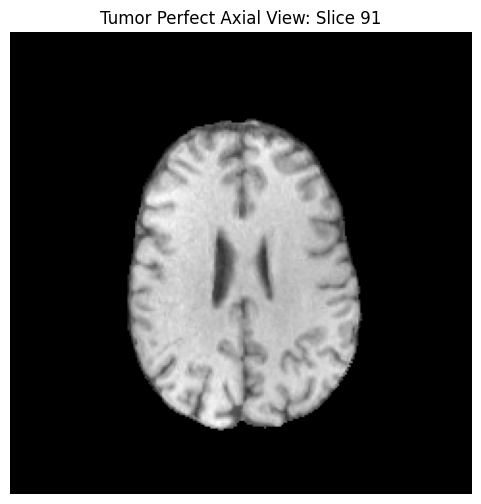

In [ ]:
import os
import nibabel as nib
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import timm
import torch.nn as nn

##############################
# Helper Functions
##############################

def load_volume_in_axial(file_path):
    """
    Loads a NIfTI file, reorients it to canonical (RAS) orientation,
    and returns a 3D numpy array representing the volume.
    If the volume is 4D, only the first timepoint is returned.
    """
    img = nib.load(file_path)
    img_canonical = nib.as_closest_canonical(img)
    data = img_canonical.get_fdata()
    if data.ndim == 4:
        data = data[..., 0]
    return data

def safe_normalize(slice_img):
    """
    Normalize a 2D numpy array (slice) to the range [0, 255] as uint8.
    """
    slice_min = np.min(slice_img)
    slice_max = np.max(slice_img)
    if (slice_max - slice_min) < 1e-8:
        return np.zeros_like(slice_img, dtype=np.uint8)
    norm = (slice_img - slice_min) / (slice_max - slice_min) * 255
    return norm.astype(np.uint8)

def infer_volume(model, file_path, before=5, after=40, transform=None, device=torch.device("cpu")):
    """
    Performs volume-level inference:
      - Loads the volume in axial view.
      - Extracts slices from (middle-before) to (middle+after).
      - For each slice, applies the specified transform and runs inference.
      - Aggregates the per-slice softmax probabilities to yield a final prediction.
      
    Returns:
      final_prediction: The predicted class (0 for Non-Tumor, 1 for Tumor).
      mean_prob: Averaged softmax probability vector.
    """
    model.eval()
    volume = load_volume_in_axial(file_path)
    num_slices = volume.shape[2]
    mid = num_slices // 2
    lower_bound = max(mid - before, 0)
    upper_bound = min(mid + after, num_slices - 1)
    
    softmax = torch.nn.Softmax(dim=1)
    all_probs = []
    for slice_idx in range(lower_bound, upper_bound + 1):
        slice_img = volume[:, :, slice_idx]
        norm_img = safe_normalize(slice_img)
        pil_img = Image.fromarray(norm_img).convert("L")
        if transform is not None:
            input_tensor = transform(pil_img).unsqueeze(0)  # shape: (1, C, H, W)
        else:
            input_tensor = transforms.ToTensor()(pil_img).unsqueeze(0)
        input_tensor = input_tensor.to(device)
        
        with torch.no_grad():
            logits = model(input_tensor)
            probs = softmax(logits)  # shape: (1, num_classes)
            all_probs.append(probs.cpu().numpy()[0])
    
    all_probs = np.array(all_probs)  # shape: (num_selected_slices, num_classes)
    mean_prob = np.mean(all_probs, axis=0)
    final_prediction = int(np.argmax(mean_prob))
    return final_prediction, mean_prob

def visualize_external_volume(file_path, predicted_label, threshold_factor=0.1):
    """
    Visualizes a "perfect axial view" of the external volume.
      - If predicted as Tumor (1): selects the slice with the highest intensity sum.
      - If predicted as Non-Tumor (0): selects the slice with the largest cross-sectional brain area.
    
    The function loads the volume, selects the appropriate slice, normalizes it, and displays it.
    """
    volume = load_volume_in_axial(file_path)
    num_slices = volume.shape[2]
    
    if predicted_label == 1:
        # Tumor: choose the slice with the highest intensity sum.
        slice_sums = [np.sum(volume[:, :, i]) for i in range(num_slices)]
        chosen_index = int(np.argmax(slice_sums))
        label_str = "Tumor"
    else:
        # Non-Tumor: choose the slice with the largest cross-sectional brain area.
        global_max = np.max(volume)
        if global_max < 1e-8:
            chosen_index = num_slices // 2
        else:
            threshold = threshold_factor * global_max
            best_area = 0
            chosen_index = 0
            for i in range(num_slices):
                slice_img = volume[:, :, i]
                mask = (slice_img >= threshold).astype(np.uint8)
                area = np.sum(mask)
                if area > best_area:
                    best_area = area
                    chosen_index = i
            label_str = "Non-Tumor"
    slice_img = volume[:, :, chosen_index]
    norm_img = safe_normalize(slice_img)
    plt.figure(figsize=(6,6))
    plt.imshow(norm_img.T, cmap="gray", origin="lower")
    plt.title(f"{label_str} Perfect Axial View: Slice {chosen_index}")
    plt.axis("off")
    plt.show()

##############################
# Model and Inference Section
##############################

# Define device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transform used during training.
slice_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load trained model.
model = timm.create_model('efficientnet_b0', pretrained=True, in_chans=1)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)
model.load_state_dict(torch.load('best_efficientnet_model.pth', map_location=device))
model = model.to(device)

# Set external file path 
external_file_path = r"/home/ec2-user/BraTS_ML_Project/data/UPenn_GBM/images/UPENN-GBM-00001_11/UPENN-GBM-00001_11_T1.nii.gz"

# Run volume-level inference.
pred_label, pred_prob = infer_volume(model, external_file_path, before=5, after=40, transform=slice_transform, device=device)
label_str = "Tumor" if pred_label == 1 else "Non-Tumor"
print(f"External File: {os.path.basename(external_file_path)}")
print(f"Predicted Label: {label_str}")
print(f"Aggregated Probabilities: {pred_prob}")

# Visualize the "perfect axial view" based on predicted label.
visualize_external_volume(external_file_path, predicted_label=pred_label, threshold_factor=0.1)


In [ ]:
import torch

# -------------------------------
# Option 1: Save the model's state_dict
# -------------------------------
state_dict_path = 'final_tumor_recognition_model.pth'
torch.save(model.state_dict(), state_dict_path)
print(f"Model state_dict saved to {state_dict_path}")
# -------------------------------
# Option 2: Save a TorchScript version of the model
# -------------------------------
# Create a dummy input tensor that matches model's input shape (1, C, H, W).
dummy_input = torch.randn(1, 1, 224, 224).to(model.device if hasattr(model, 'device') else torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Trace the model using the dummy input.
traced_model = torch.jit.trace(model, dummy_input)

# Save the traced model.
script_model_path = 'final_tumor_recognition_model_script.pt'
torch.jit.save(traced_model, script_model_path)
print(f"TorchScript model saved to {script_model_path}")

Model state_dict saved to final_tumor_recognition_model.pth
TorchScript model saved to final_tumor_recognition_model_script.pt
